# SVM and Logistic Regression for Wine-Quality Prediction

## Import libraries:
- pandas and numpy: Used for data manipulation and numerical operations.

- seaborn and matplotlib.pyplot: Used for data visualization.

- #### Custom functions and classes:

    - count_outliers: A utility function to determine the number of outliers in the dataset.

    -   SVM, SVMKernel, LogisticRegression, LogisticRegressionKernel: Custom-built models for classification.

    -   nested_k_fold_cross_validation: A function to perform model tuning and evaluation using 5-fold nested cross-validation.

    -   print_results: A helper function to display the performance metrics from the training and testing phases.

### Random state:

To ensure the reproducibility of this project, the `RANDOM_STATE` variable is set to `42`. Using this constant across all stochastic processes guarantees that the results are deterministic and can be replicated exactly.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from classes.outliers import count_outliers
from models.svm import SVM, SVMKernel
from models.lr import LogisticRegression, LogisticRegressionKernel
from classes.nested_cv import nested_k_fold_cross_validation
from classes.evaluation import print_results

RANDOM_STATE = 42

## Loading Wine Quality Dataset

The dataset is located in the `/dataset` directory and consists of three files:

 - winequality-red.csv: Contains features of red wines.

 - winequality-white.csv: Contains features of white wines.

 - winequality.names: Describes the dataset and its features.

The red and white wine datasets are loaded into separate DataFrames (`X1` and `X2`, respectively) and then concatenated into a single DataFrame, `X`, which will be used for the project.

In [2]:
X1 = pd.read_csv('dataset/winequality-red.csv', sep = ";")
X2 = pd.read_csv('dataset/winequality-white.csv', sep = ";")
X = pd.concat([X1, X2], ignore_index=True)

## Exploration of the dataset
### Information about the dataset
The `.info()` method is used to display a concise summary of the dataset's structure, including:
- The count of non-null values for each feature.

- The data type of each variable (dtypes).

- The memory usage.

In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 609.2 KB


The output confirms that all feature columns are of type `float64`, while the target variable, quality, is `int64`. Therefore, no data type conversions are necessary. However, for binary classification, the quality label needs to be binarized based on the following rule:

- quality >= 6 is mapped to +1 (good wine).

- quality < 6 is mapped to -1 (bad wine).

In [4]:
X['quality'] = X['quality'].apply(lambda x: 1 if x >= 6 else -1)

### Distribution of the label

Analyzing the label distribution is a crucial step. An imbalanced dataset, where one class significantly outnumbers the other, can lead to models that are biased towards the majority class, resulting in poor performance on the minority class.

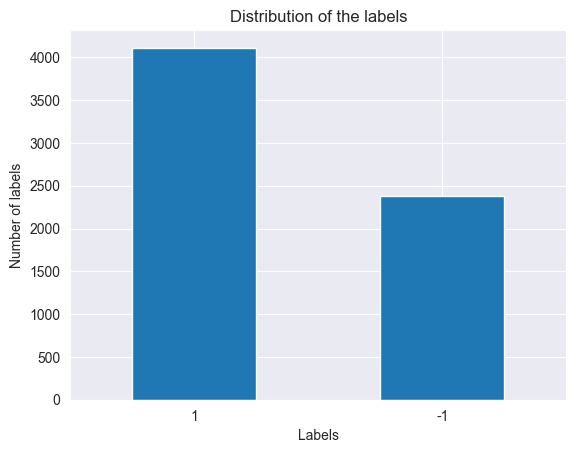

quality
 1    4113
-1    2384
Name: count, dtype: int64


In [5]:
number_of_labels = X['quality'].value_counts()
number_of_labels.plot(kind='bar')
plt.title('Distribution of the labels')
plt.xlabel('Labels')
plt.ylabel('Number of labels')
plt.xticks(rotation=0)
plt.show()
print(number_of_labels)

The output clearly shows that the number of +1 labels (good wines) is nearly double the number of -1 labels (bad wines). This confirms that the dataset is imbalanced, suggesting that a data augmentation technique should be employed during training to mitigate this issue.

The `.describe()` method provides key statistical information for each feature, including mean, standard deviation, and quartiles. This is particularly useful for identifying potential outliers by comparing the third quartile (75%) with the maximum value.

In [6]:
X.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,0.266123
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.964013
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,-1.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,-1.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,1.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,1.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,1.000000


A significant gap between the 75th percentile and the maximum value is observed for several features, notably:

- `residual sugar` (8.10 vs 65.80)

- `free sulfur dioxide` (41.00 vs 289.00)

- `total sulfur dioxide` (156.00 vs 440.00)

This discrepancy strongly suggests the presence of outliers. To quantify them precisely, the Interquartile Range (IQR) method is applied using the custom count_outliers function.

In [7]:
print(f"{'Column':<25} | {'Outliers'}")
print("-" * 37)

for column in X.columns:
    print(f"{column:<25} | {count_outliers(X.copy(), column)}")

Column                    | Outliers
-------------------------------------
fixed acidity             | 357
volatile acidity          | 377
citric acid               | 509
residual sugar            | 118
chlorides                 | 286
free sulfur dioxide       | 62
total sulfur dioxide      | 10
density                   | 3
pH                        | 73
sulphates                 | 191
alcohol                   | 3
quality                   | 0


The output from the `count_outliers` function is essential for deciding on an appropriate outlier treatment strategy. The feature citric acid has the highest count with 509 outliers. Given these high numbers across several features, it is clear that methods involving the removal of outliers (e.g., trimming) are unsuitable. Such an approach would lead to a significant loss of data, which is especially problematic for a dataset that is already imbalanced.

## Correlation Matrix

Correlation quantifies the strength and direction of the linear relationship between variables. Its values lie in the range [−1, +1], where:
- −1 indicates a perfect negative correlation (inverse linear relationship);
- +1 indicates a perfect positive correlation (direct linear relationship);
-  0 indicates the absence of a linear correlation.

Correlation is computed by using `.corr()` method and plotted using methods of `plt`.

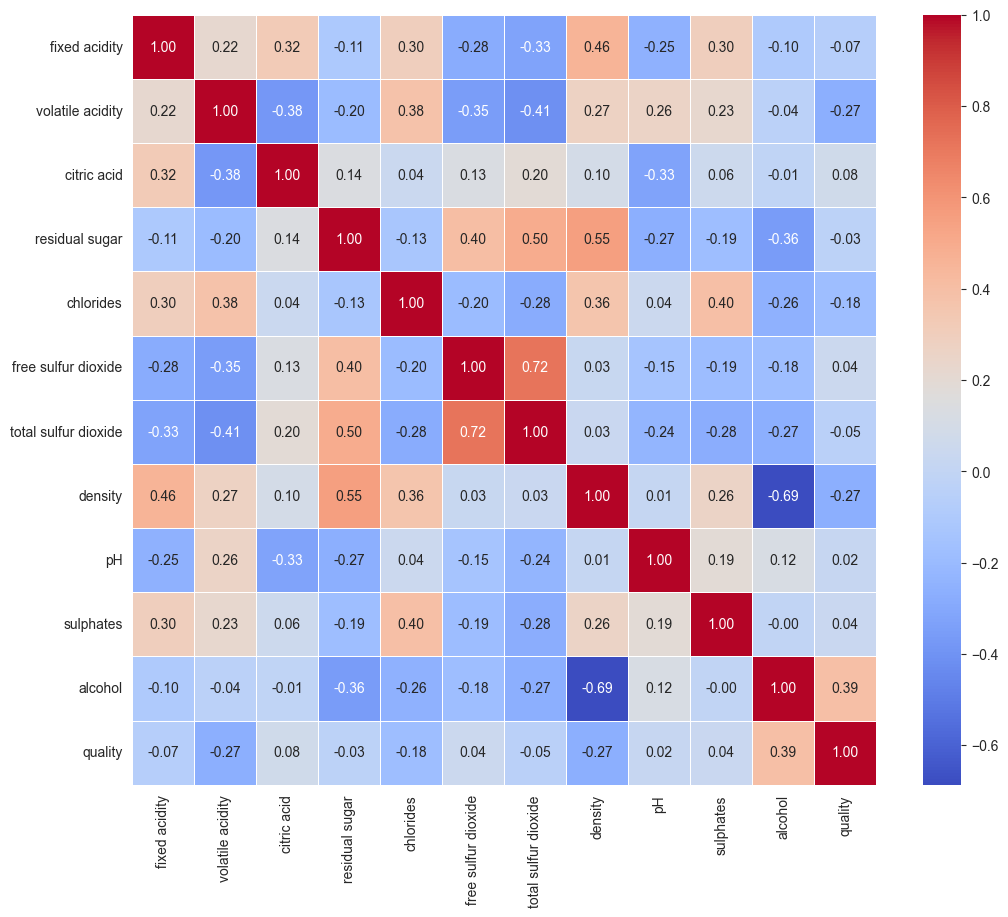

In [8]:
# Correlation matrix
correlation_matrix = X.corr()

# Figure
plt.figure(figsize=(12, 10))

# Heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.show()

#### Strongest Positive Correlations:

- `free sulfur dioxide` and `total sulfur dioxide` exhibit a strong correlation of 0.72. This suggests high multicollinearity.

- `density` and `residual sugar` have a correlation of 0.55.

- `quality` and `alcohol` show a correlation of 0.39, making `alcohol` the most correlated feature with the target variable.

#### Strongest Negative Correlation:

- `alcohol` and `density` have a strong negative correlation of -0.69.

## Preparation of feature and label sets

### Feature and label separation
Based on the correlation analysis, the `total sulfur dioxide` feature was removed from the feature set to reduce multicollinearity, given its strong correlation with free sulfur dioxide. The quality column was isolated as the target variable (labels), and the remaining columns were designated as the feature set. Finally, both sets were converted to NumPy arrays for use in the models.

In [9]:
# remove 'quality' from feature set
features = X.drop('quality', axis=1)
# remove 'total sulfur dioxide' because of high correlation
features = features.drop('total sulfur dioxide', axis=1)
# initialize label set
labels = X['quality']

# conversion to numpy
features = features.to_numpy()
labels = labels.to_numpy()

## Nested k-fold cross validation for tuning and evaluation

For each model (SVM, Logistic Regression, SVM with Gaussian Kernel, SVM with Polynomial Kernel, Logistic Regression with Gaussian Kernel, Logistic Regression with Polynomial Kernel) it is performed a nested k-fold cross validation, with `n_outer_folds=5, n_inner_folds=4` and `random_state_cv = RANDOM_STATE`). All models are also initialized with the same `random_state` coefficient to guarantee reproducibility).

### Nested k-fold cross validation process

A nested k-fold cross-validation procedure (`n_outer_folds=5, n_inner_folds=4`) is performed for each of the six models. The random_state is fixed to ensure reproducibility for both the cross-validation splits and the model initializations.

Process Overview:
The entire preprocessing pipeline occurs within each fold of the cross-validation to prevent data leakage. Specifically, for each train/test split, the following steps are applied exclusively to the training data:

- Logarithmic Transformation: To reduce the impact of outliers.

- Z-score Scaling: To standardize the feature values.

- SMOTE (Synthetic Minority Over-sampling Technique): To balance the class distribution via data augmentation.

Furthermore, the data splitting process uses stratification to ensure that the original class distribution is maintained in each fold. The nested validation consists of two loops:

- Inner Loop: Performs grid search with cross-validation to find the optimal set of hyperparameters.

- Outer Loop: Provides an unbiased evaluation of the model's performance using the best hyperparameters found in the inner loop.

In [10]:
models = {
        'SVM': {
        'class': SVM,
        'param_grid': {
            'lambda_reg': [0.001, 0.02, 0.04, 0.08, 0.1],
            'n_iters': [20000, 25000, 30000]
        },
        'random_state': RANDOM_STATE
    },
        'Logistic Regression': {
            'class': LogisticRegression,
            'param_grid': {
                'learning_rate': [0.005, 0.0075, 0.01, 0.05],
                'lambda_reg': [0.005, 0.001, 0.0005, 0.01, 0.0001],
                'n_iters': [20000, 22500, 25000]
            },
        'random_state': RANDOM_STATE
    },
    'SVM Kernel Gaussian': {
            'class': SVMKernel,
            'param_grid': {
                'kernel': ['gaussian'],
                'lambda_reg': [0.001, 0.01],
                'gamma': [1, 1.5, 2, 2.5, 3],
                'eta_b': [0.01, 0.001],
                'n_iters': [25000, 30000]
            },
        'random_state': RANDOM_STATE
    },
        'SVM Kernel Polynomial': {
                'class': SVMKernel,
                'param_grid': {
                    'kernel': ['polynomial'],
                    'lambda_reg': [0.001, 0.01, 0.1],
                    'degree': [1, 2, 3],
                    'eta_b': [0.01, 0.001],
                    'n_iters': [25000, 30000]
                },
        'random_state': RANDOM_STATE
    },
        'Logistic Regression Kernel Polynomial': {
            'class': LogisticRegressionKernel,
            'param_grid': {
                'kernel': ['polynomial'],
                'degree': [3, 4, 5],
                'lambda_reg': [0.01, 0.1],
                'learning_rate': [0.001, 0.0001],
                'n_iters': [25000, 30000]
                },
        'random_state': RANDOM_STATE
    },
        'Logistic Regression Kernel Gaussian': {
        'class': LogisticRegressionKernel,
        'param_grid': {
            'kernel': ['gaussian'],
            'lambda_reg': [0.001, 0.01],
            'gamma': [1, 2, 3],
            'learning_rate': [0.01, 0.001],
            'n_iters': [25000, 30000]
        },
        'random_state': RANDOM_STATE
    }

}

# compute nested k-fold cross validation across all the models employed
models_res = nested_k_fold_cross_validation(features, labels, models, random_state_cv=RANDOM_STATE, n_outer_folds=5, n_inner_folds=4)

=== SVM ===
=== Outer Fold 1 ===
Best hyperparams: {'lambda_reg': 0.02, 'n_iters': 20000} in outer fold 1
[Outer Fold 1] Accuracy: 0.7300, Precision: 0.8371, Recall: 0.7120, F1 score: 0.7695
=== Outer Fold 2 ===
Best hyperparams: {'lambda_reg': 0.02, 'n_iters': 20000} in outer fold 2
[Outer Fold 2] Accuracy: 0.7038, Precision: 0.8269, Recall: 0.6731, F1 score: 0.7421
=== Outer Fold 3 ===
Best hyperparams: {'lambda_reg': 0.02, 'n_iters': 25000} in outer fold 3
[Outer Fold 3] Accuracy: 0.7115, Precision: 0.8173, Recall: 0.7011, F1 score: 0.7547
=== Outer Fold 4 ===
Best hyperparams: {'lambda_reg': 0.02, 'n_iters': 20000} in outer fold 4
[Outer Fold 4] Accuracy: 0.7221, Precision: 0.8336, Recall: 0.7007, F1 score: 0.7614
=== Outer Fold 5 ===
Best hyperparams: {'lambda_reg': 0.02, 'n_iters': 25000} in outer fold 5
[Outer Fold 5] Accuracy: 0.7280, Precision: 0.8271, Recall: 0.7214, F1 score: 0.7706
=== Logistic Regression ===
=== Outer Fold 1 ===
Best hyperparams: {'learning_rate': 0.005, '

## Results of models

Using `model_res` it is possible to extract all the outcomes for each evaluated model by using `print_results` method:
- training metrics (Accuracy, Precision, Recall, F1 score);
- test metrics (Accuracy, Precision, Recall, F1 score);
- training and test error;
- best hyperparameters for each outer loop;
- results for each class.

In [11]:
# print results
print("================================ SVM ================================\n")
print_results(models_res['SVM'])
print("\n\n================================ LR ================================\n")
print_results(models_res['Logistic Regression'])
print("\n\n================================ SVM Kernel Gaussian ================================\n")
print_results(models_res['SVM Kernel Gaussian'])
print("\n\n================================ SVM Kernel Polynomial ================================\n")
print_results(models_res['SVM Kernel Polynomial'])
print("\n\n================================ LR Kernel Gaussian ================================\n")
print_results(models_res['Logistic Regression Kernel Gaussian'])
print("\n\n================================ LR Kernel Polynomial ================================\n")
print_results(models_res['Logistic Regression Kernel Polynomial'])

================================ SVM ================================

==================== TRAINING METRICS ======================
Accuracy: 72.69%, std: 0.26%
Precision: 73.94%, std: 0.32%
Recall: 70.09%, std: 0.49%
F1 score: 71.96%, std: 0.30%
====================== TEST METRICS ========================
Accuracy: 71.91%, std: 1.00%
Precision: 82.84%, std: 0.68%
Recall: 70.17%, std: 1.62%
F1 score: 75.97%, std: 1.05%
================ TRAINING AND TEST ERROR ===================
Training error: 0.27, std: 0.00%
Test error: 0.28, std: 0.01%
================== BEST HYPERPARAMETERS ====================
{'lambda_reg': 0.02, 'n_iters': 20000}
{'lambda_reg': 0.02, 'n_iters': 20000}
{'lambda_reg': 0.02, 'n_iters': 25000}
{'lambda_reg': 0.02, 'n_iters': 20000}
{'lambda_reg': 0.02, 'n_iters': 25000}
==================== RESULTS FOR CLASSES ===================
Precision +1: 82.84%, std: 0.68%
Precision -1: 59.30%, std: 1.24%
Recall +1: 70.17%, std: 1.62%
Recall -1: 74.92%, std: 1.24%
F1 score +1

#### Repetition of Logistic Regression Kernel Gaussian

By looking at the best hyperparameters chosen for Logistic Regression Kernel Gaussian:

{'kernel': 'gaussian', 'lambda_reg': 0.001, 'gamma': 3, 'learning_rate': 0.01, 'n_iters': 25000}

{'kernel': 'gaussian', 'lambda_reg': 0.001, 'gamma': 3, 'learning_rate': 0.01, 'n_iters': 30000}

{'kernel': 'gaussian', 'lambda_reg': 0.001, 'gamma': 3, 'learning_rate': 0.01, 'n_iters': 30000}

{'kernel': 'gaussian', 'lambda_reg': 0.001, 'gamma': 3, 'learning_rate': 0.01, 'n_iters': 25000}

{'kernel': 'gaussian', 'lambda_reg': 0.001, 'gamma': 3, 'learning_rate': 0.01, 'n_iters': 25000}

Given the stability of the selected hyperparameters, it is worth exploring higher values for gamma to determine if further performance improvements can be achieved.

In [12]:
lr_opt = {
    'Logistic Regression Kernel Gaussian': {
        'class': LogisticRegressionKernel,
        'param_grid': {
            'kernel': ['gaussian'],
            'lambda_reg': [0.001],
            'gamma': [3, 4, 5],
            'learning_rate': [0.01, 0.001],
            'n_iters': [25000, 30000]
        },
        'random_state': RANDOM_STATE
    }
}

lr_opt_res = nested_k_fold_cross_validation(features, labels, lr_opt, random_state_cv=RANDOM_STATE, n_outer_folds=5, n_inner_folds=4)

=== Logistic Regression Kernel Gaussian ===
=== Outer Fold 1 ===
Best hyperparams: {'kernel': 'gaussian', 'lambda_reg': 0.001, 'gamma': 4, 'learning_rate': 0.01, 'n_iters': 25000} in outer fold 1
[Outer Fold 1] Accuracy: 0.7369, Precision: 0.8317, Recall: 0.7327, F1 score: 0.7791
=== Outer Fold 2 ===
Best hyperparams: {'kernel': 'gaussian', 'lambda_reg': 0.001, 'gamma': 5, 'learning_rate': 0.01, 'n_iters': 30000} in outer fold 2
[Outer Fold 2] Accuracy: 0.7200, Precision: 0.8483, Recall: 0.6792, F1 score: 0.7544
=== Outer Fold 3 ===
Best hyperparams: {'kernel': 'gaussian', 'lambda_reg': 0.001, 'gamma': 5, 'learning_rate': 0.01, 'n_iters': 30000} in outer fold 3
[Outer Fold 3] Accuracy: 0.7200, Precision: 0.8293, Recall: 0.7023, F1 score: 0.7605
=== Outer Fold 4 ===
Best hyperparams: {'kernel': 'gaussian', 'lambda_reg': 0.001, 'gamma': 5, 'learning_rate': 0.01, 'n_iters': 25000} in outer fold 4
[Outer Fold 4] Accuracy: 0.7360, Precision: 0.8436, Recall: 0.7153, F1 score: 0.7742
=== Oute

In [13]:
print_results(lr_opt_res['Logistic Regression Kernel Gaussian'])

==================== TRAINING METRICS ======================
Accuracy: 73.59%, std: 0.26%
Precision: 75.78%, std: 0.83%
Recall: 69.39%, std: 1.85%
F1 score: 72.42%, std: 0.69%
====================== TEST METRICS ========================
Accuracy: 72.37%, std: 1.16%
Precision: 83.95%, std: 0.76%
Recall: 69.71%, std: 2.70%
F1 score: 76.13%, std: 1.45%
================ TRAINING AND TEST ERROR ===================
Training error: 0.26, std: 0.00%
Test error: 0.28, std: 0.01%
================== BEST HYPERPARAMETERS ====================
{'kernel': 'gaussian', 'lambda_reg': 0.001, 'gamma': 4, 'learning_rate': 0.01, 'n_iters': 25000}
{'kernel': 'gaussian', 'lambda_reg': 0.001, 'gamma': 5, 'learning_rate': 0.01, 'n_iters': 30000}
{'kernel': 'gaussian', 'lambda_reg': 0.001, 'gamma': 5, 'learning_rate': 0.01, 'n_iters': 30000}
{'kernel': 'gaussian', 'lambda_reg': 0.001, 'gamma': 5, 'learning_rate': 0.01, 'n_iters': 25000}
{'kernel': 'gaussian', 'lambda_reg': 0.001, 'gamma': 5, 'learning_rate': 0.0

## Common errors

For the error analysis, it is useful to identify the subset of samples that are misclassified by all models. This allows us to quantify the number of examples that are inherently difficult to predict.

In [28]:
model_keys = [
    'SVM',
    'Logistic Regression',
    'SVM Kernel Gaussian',
    'SVM Kernel Polynomial',
    'Logistic Regression Kernel Gaussian',
    'Logistic Regression Kernel Polynomial'
]

error_indices_list = [set(models_res[key]['oof_errors']['sample_index']) for key in model_keys]

if error_indices_list:
    common_indices_total = set.intersection(*error_indices_list)
else:
    common_indices_total = set()

print(f"\nNumber of common errors between models: {len(common_indices_total)}")

for i, key in enumerate(model_keys):
    print(f"Errors of {key}: {len(error_indices_list[i])}, common errors: {(len(common_indices_total)/len(error_indices_list[i])) * 100:.2f}")

if common_indices_total:

    reference_errors = models_res[model_keys[0]]['oof_errors']
    filtered_errors_total = reference_errors[reference_errors['sample_index'].isin(common_indices_total)]

    label_counts_total = filtered_errors_total['true_label'].value_counts()

    print("\nCounter of labels for common errors:")
    print(label_counts_total)
else:
    print("\nNo common errors between models.")


Number of common errors between models: 1047
Errors of SVM: 1825, common errors: 57.37
Errors of Logistic Regression: 1795, common errors: 58.33
Errors of SVM Kernel Gaussian: 1612, common errors: 64.95
Errors of SVM Kernel Polynomial: 1720, common errors: 60.87
Errors of Logistic Regression Kernel Gaussian: 1742, common errors: 60.10
Errors of Logistic Regression Kernel Polynomial: 1721, common errors: 60.84

Counter of labels for common errors:
true_label
 1    702
-1    345
Name: count, dtype: int64


## Statistical properties of common errors

To identify the characteristics that define these hard-to-classify samples, their statistical properties are examined and compared to those of the easily classified samples.

In [15]:
common_indices_list = list(common_indices_total)
common_errors = X.loc[common_indices_list]
not_common_errors = X.drop(common_indices_list)

In [16]:
print("--- Common Errors ---")
common_errors.describe()

--- Common Errors ---


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1047.000000,1047.000000,1047.000000,1047.00000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000
mean,7.197899,0.358510,0.311681,5.74766,0.058768,31.351003,119.846227,0.995442,3.225454,0.518873,10.037198,0.340974
std,1.162121,0.163976,0.146259,4.86241,0.031803,19.418279,60.981631,0.002573,0.154994,0.122758,0.932908,0.940522
min,4.600000,0.120000,0.000000,0.70000,0.009000,3.000000,7.000000,0.987400,2.770000,0.250000,8.500000,-1.000000
25%,6.450000,0.250000,0.240000,1.87500,0.042000,17.000000,72.000000,0.993535,3.120000,0.430000,9.300000,-1.000000
50%,7.000000,0.300000,0.300000,3.30000,0.049000,29.000000,126.000000,0.995600,3.210000,0.500000,9.800000,1.000000
75%,7.600000,0.440000,0.400000,8.65000,0.070000,42.000000,164.000000,0.997280,3.320000,0.590000,10.600000,1.000000
max,15.900000,1.040000,0.990000,22.60000,0.415000,289.000000,440.000000,1.003690,3.900000,1.620000,14.900000,1.000000


In [17]:
print("--- Not Common Errors ---")
not_common_errors.describe()

--- Not Common Errors ---


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,5450.000000,5450.000000,5450.000000,5450.000000,5450.000000,5450.000000,5450.000000,5450.000000,5450.000000,5450.000000,5450.000000,5450.000000
mean,7.218651,0.336046,0.319969,5.384752,0.055509,30.366697,114.956606,0.994554,3.217165,0.533650,10.579135,0.251743
std,1.320745,0.164531,0.145112,4.735657,0.035599,17.407923,55.595478,0.003053,0.161856,0.153199,1.217166,0.967883
min,3.800000,0.080000,0.000000,0.600000,0.012000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,-1.000000
25%,6.400000,0.220000,0.250000,1.800000,0.037000,17.000000,79.000000,0.992082,3.110000,0.430000,9.500000,-1.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,117.000000,0.994675,3.210000,0.510000,10.400000,1.000000
75%,7.700000,0.400000,0.390000,8.000000,0.063000,41.000000,153.000000,0.996897,3.320000,0.600000,11.400000,1.000000
max,15.600000,1.580000,1.660000,65.800000,0.611000,146.500000,366.500000,1.038980,4.010000,2.000000,14.200000,1.000000


Recalling the correlation analysis, it is clear that alcohol (+0.39 correlation with quality) and volatile acidity (-0.27 correlation) play a key role in the classification. The tables above confirm their importance in explaining misclassifications.

Specifically, the alcohol values for the commonly misclassified samples are more centered (lower mean and much smaller standard deviation) compared to the easily classified samples. This indicates a weak primary signal. Furthermore, these same difficult samples exhibit a higher mean volatile acidity, a trait associated with lower quality. These properties are distinct from the easily classified samples, suggesting that the combination of a weak primary signal (alcohol) and a conflicting secondary signal (volatile acidity) makes it difficult for the models to determine the correct class.

## Plot of loss curves

To understand the training dynamics of each model, their learning curves are plotted below. Since a nested k-fold cross-validation was used, each curve represents the average loss across the outer folds. The plot begins at the 500th iteration to avoid the large initial loss values from some models, which would obscure the details of the later convergence process.

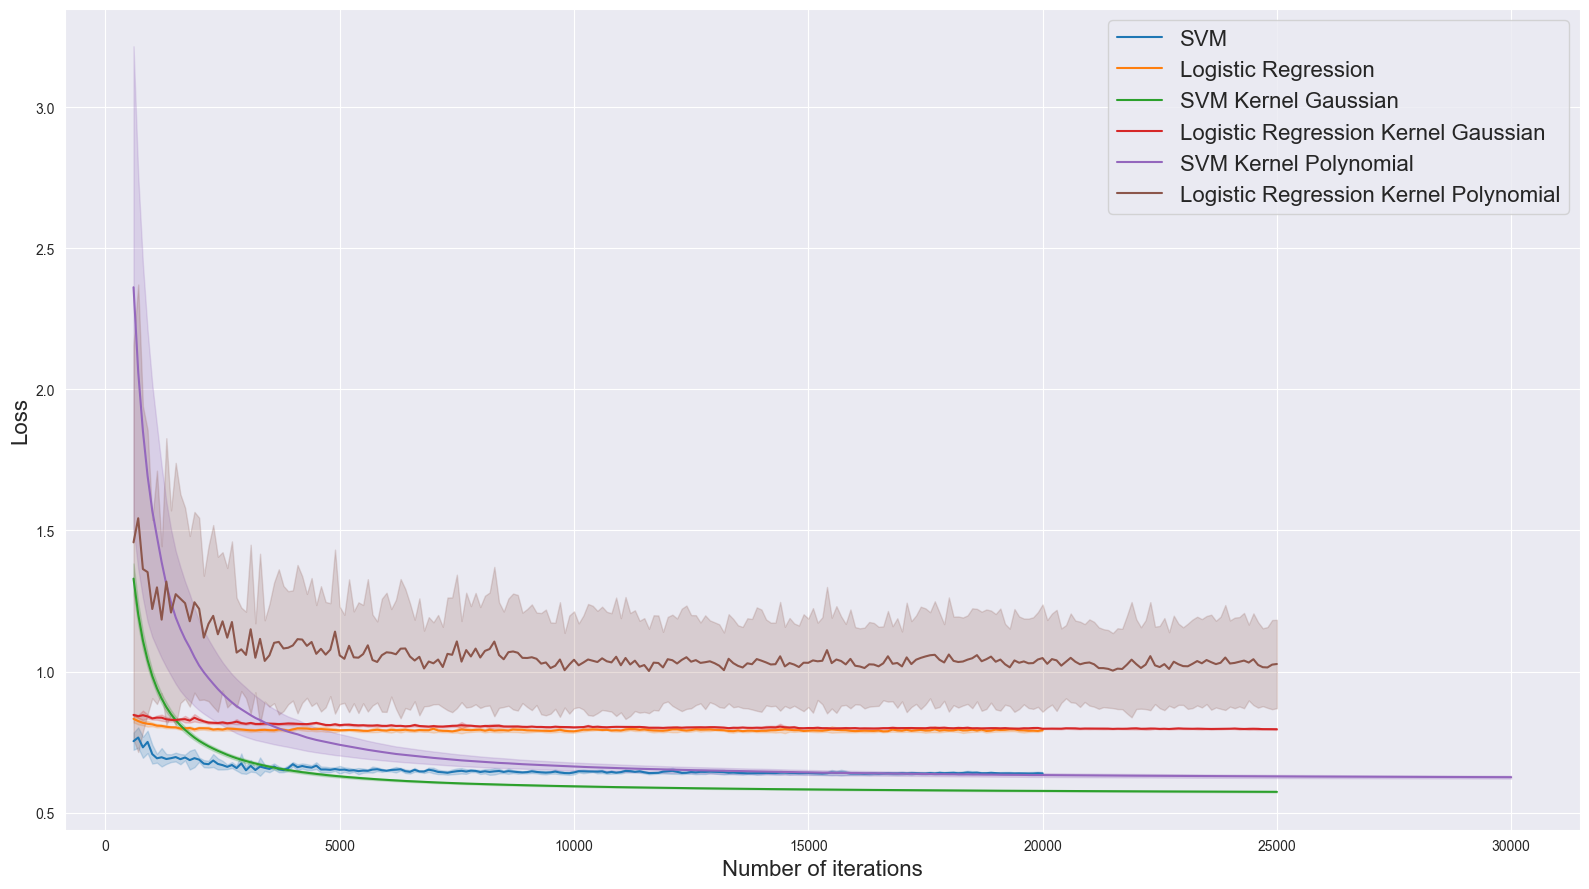

In [18]:
fig, ax = plt.subplots(figsize=(16, 9))

for key in model_keys:
    loss_curves_for_model = models_res[key]['loss_curves']

    if not loss_curves_for_model or not any(loss_curves_for_model):
        print(f"No loss found for: {key}")
        continue

    min_len = min(len(curve) for curve in loss_curves_for_model)
    aligned_curves = [curve[:min_len] for curve in loss_curves_for_model]
    loss_array = np.array(aligned_curves)

    mean_loss = np.mean(loss_array, axis=0)
    std_loss = np.std(loss_array, axis=0)

    iterations = np.arange(100, (len(mean_loss) * 100) + 1, 100)

    x_values = iterations[5:]
    y_values_mean = mean_loss[5:]
    y_values_std = std_loss[5:]

    line, = ax.plot(x_values, y_values_mean, label=key)
    ax.fill_between(x_values,
                    y_values_mean - y_values_std,
                    y_values_mean + y_values_std,
                    color=line.get_color(),
                    alpha=0.2)

ax.set_xlabel('Number of iterations', fontsize=16)
ax.set_ylabel('Loss', fontsize=16)
ax.legend(fontsize=16)
ax.grid(True)
plt.tight_layout()
plt.show()

As the plot shows, while some models exhibit a smooth decrease in loss (e.g., SVM with kernels), others are affected by oscillations that indicate instability in the convergence. This is particularly evident in the Logistic Regression with a Polynomial kernel, where the loss values swing without consistently converging to a stable low value. The linear SVM also shows initial oscillations; however, the phenomenon becomes less pronounced after approximately 5000 iterations.

To investigate the instability observed with the Logistic Regression Polynomial kernel, a second evaluation was conducted. This time, the theoretically exact regularization technique was applied by setting 'use_exact_reg' = True. This method is expected to achieve better results than the weight decay approximation. Due to the high computational cost of this method, the grid search was minimal and performed with fewer iterations to find a reasonable set of hyperparameters.

In [19]:
lr = {
    'Logistic Regression Kernel Polynomial': {
            'class': LogisticRegressionKernel,
            'param_grid': {
                'kernel': ['polynomial'],
                'degree': [3, 4],
                'lambda_reg': [0.001, 0.01],
                'learning_rate': [0.001, 0.0001],
                'n_iters': [3000],
                'use_exact_reg': [True]
                },
        'random_state': RANDOM_STATE
    }
}

lr_res = nested_k_fold_cross_validation(features, labels, lr, random_state_cv=RANDOM_STATE, n_inner_folds=4, n_outer_folds=5)

=== Logistic Regression Kernel Polynomial ===
=== Outer Fold 1 ===
Best hyperparams: {'kernel': 'polynomial', 'degree': 4, 'lambda_reg': 0.001, 'learning_rate': 0.0001, 'n_iters': 3000, 'use_exact_reg': True} in outer fold 1
[Outer Fold 1] Accuracy: 0.7362, Precision: 0.8166, Recall: 0.7521, F1 score: 0.7830
=== Outer Fold 2 ===
Best hyperparams: {'kernel': 'polynomial', 'degree': 4, 'lambda_reg': 0.001, 'learning_rate': 0.0001, 'n_iters': 3000, 'use_exact_reg': True} in outer fold 2
[Outer Fold 2] Accuracy: 0.7138, Precision: 0.8321, Recall: 0.6865, F1 score: 0.7523
=== Outer Fold 3 ===
Best hyperparams: {'kernel': 'polynomial', 'degree': 4, 'lambda_reg': 0.001, 'learning_rate': 0.0001, 'n_iters': 3000, 'use_exact_reg': True} in outer fold 3
[Outer Fold 3] Accuracy: 0.7123, Precision: 0.8268, Recall: 0.6902, F1 score: 0.7523
=== Outer Fold 4 ===
Best hyperparams: {'kernel': 'polynomial', 'degree': 4, 'lambda_reg': 0.001, 'learning_rate': 0.0001, 'n_iters': 3000, 'use_exact_reg': True}

To directly compare the two regularization methods, a final nested k-fold cross-validation was performed for each, using their respective best-found hyperparameters.

In [20]:
lr = {
    'Logistic Regression Kernel Polynomial Exact Regularization': {
            'class': LogisticRegressionKernel,
            'param_grid': {
                'kernel': ['polynomial'],
                'degree': [4],
                'lambda_reg': [0.001],
                'learning_rate': [0.0001],
                'n_iters': [27500],
                'use_exact_reg': [True]
                },
        'random_state': RANDOM_STATE
    },
    'Logistic Regression Kernel Polynomial Approximate Regularization': {
         'class': LogisticRegressionKernel,
            'param_grid': {
                'kernel': ['polynomial'],
                'degree': [5],
                'lambda_reg': [0.1],
                'learning_rate': [0.0001],
                'n_iters': [27500]
                },
        'random_state': RANDOM_STATE
    }
}

lr_res = nested_k_fold_cross_validation(features, labels, lr, random_state_cv=RANDOM_STATE, n_inner_folds=4, n_outer_folds=5)

=== Logistic Regression Kernel Polynomial Exact Regularization ===
=== Outer Fold 1 ===
Best hyperparams: {'kernel': 'polynomial', 'degree': 4, 'lambda_reg': 0.001, 'learning_rate': 0.0001, 'n_iters': 27500, 'use_exact_reg': True} in outer fold 1
[Outer Fold 1] Accuracy: 0.7277, Precision: 0.8364, Recall: 0.7084, F1 score: 0.7671
=== Outer Fold 2 ===
Best hyperparams: {'kernel': 'polynomial', 'degree': 4, 'lambda_reg': 0.001, 'learning_rate': 0.0001, 'n_iters': 27500, 'use_exact_reg': True} in outer fold 2
[Outer Fold 2] Accuracy: 0.7185, Precision: 0.8385, Recall: 0.6877, F1 score: 0.7557
=== Outer Fold 3 ===
Best hyperparams: {'kernel': 'polynomial', 'degree': 4, 'lambda_reg': 0.001, 'learning_rate': 0.0001, 'n_iters': 27500, 'use_exact_reg': True} in outer fold 3
[Outer Fold 3] Accuracy: 0.7285, Precision: 0.8426, Recall: 0.7023, F1 score: 0.7661
=== Outer Fold 4 ===
Best hyperparams: {'kernel': 'polynomial', 'degree': 4, 'lambda_reg': 0.001, 'learning_rate': 0.0001, 'n_iters': 2750

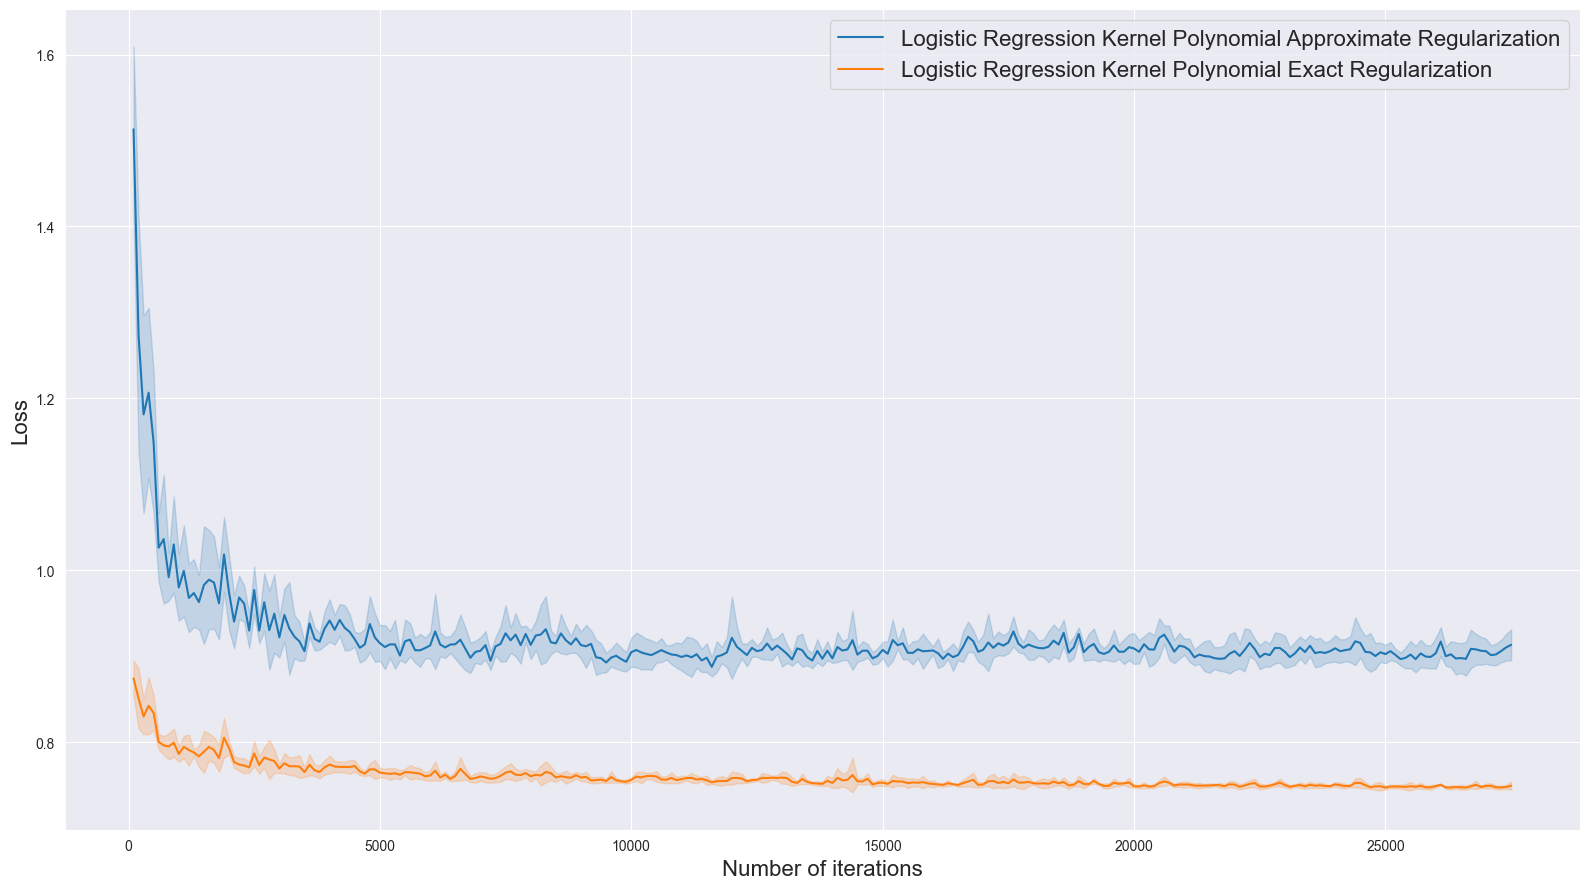

In [21]:
fig, ax = plt.subplots(figsize=(16, 9))

models_to_plot = [
    'Logistic Regression Kernel Polynomial Approximate Regularization',
    'Logistic Regression Kernel Polynomial Exact Regularization'
]

for model_key in models_to_plot:

    loss_curves_for_model = lr_res[model_key]['loss_curves']

    if not loss_curves_for_model or not any(loss_curves_for_model):
        print(f"No loss found for: {model_key}")
        continue

    min_len = min(len(curve) for curve in loss_curves_for_model)
    aligned_curves = [curve[:min_len] for curve in loss_curves_for_model]

    loss_array = np.array(aligned_curves)
    mean_loss = np.mean(loss_array, axis=0)
    std_loss = np.std(loss_array, axis=0)

    iterations = np.arange(100, (len(mean_loss) * 100) + 1, 100)

    line, = ax.plot(iterations, mean_loss, label=model_key)
    ax.fill_between(iterations,
                        mean_loss - std_loss,
                        mean_loss + std_loss,
                        color=line.get_color(),
                        alpha=0.2)

ax.set_xlabel('Number of iterations', fontsize=16)
ax.set_ylabel('Loss', fontsize=16)
ax.legend(fontsize=16)
ax.grid(True)
plt.tight_layout()
plt.show()

The resulting plot confirms that the weight decay approximation leads to an unstable convergence, and its final loss does not decrease as effectively as the exact version. This demonstrates that the kernelized Logistic Regression can be a powerful model when regularization is applied according to its exact theoretical formulation. However, the significant computational cost makes the approximation a more practical choice for large-scale experiments, despite its sub-optimal performance.